In [1611]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [1612]:
sample_submission = pd.read_csv('/home/skywatcher/Документы/Практика/math/kaggle/sample_submission.csv')

In [1613]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Id       216 non-null    int64
 1   Outcome  216 non-null    int64
dtypes: int64(2)
memory usage: 3.5 KB


In [1614]:
DATA_DIR = '/home/skywatcher/Документы/Практика/math/kaggle/'

In [1748]:
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')

Описание датасета

Датасет собран на основе исследований Национального института здравоохранения США. В нем принимали участие женщины-представительницы индейского племени Пима старше 21 года.

Датасет состоит из нескольких признаков и одной целевой переменной Outcome (0 - пациентка не больна диабетом, 1 - больна). Среди других переменных: количество беременностей, которые имела пациентка, индекс массы тела, уровень инсулина, возраст и другие.

In [1749]:
train.info()
print('Распределение целевой переменной:', '\n', train['Outcome'].value_counts(normalize=True))
print('Целевая переменная не сбалансирована')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               552 non-null    int64  
 1   Glucose                   552 non-null    int64  
 2   BloodPressure             552 non-null    int64  
 3   SkinThickness             552 non-null    int64  
 4   Insulin                   552 non-null    int64  
 5   BMI                       552 non-null    float64
 6   DiabetesPedigreeFunction  552 non-null    float64
 7   Age                       552 non-null    int64  
 8   Outcome                   552 non-null    int64  
 9   Id                        552 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 43.2 KB
Распределение целевой переменной: 
 0    0.641304
1    0.358696
Name: Outcome, dtype: float64
Целевая переменная не сбалансирована


In [1750]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Id
0,1,85,66,29,0,26.6,0.351,31,0,1
1,8,183,64,0,0,23.3,0.672,32,1,2
2,1,89,66,23,94,28.1,0.167,21,0,3
3,0,137,40,35,168,43.1,2.288,33,1,4
4,5,116,74,0,0,25.6,0.201,30,0,5


## Проверка на пропуски и нерелевантные типы данных

In [1751]:
train.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Id                          0
dtype: int64

In [1752]:
train.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Id                          0
dtype: int64

## Удаление выбросов
### Поиск по порогу

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>],
       [<AxesSubplot:title={'center':'Id'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

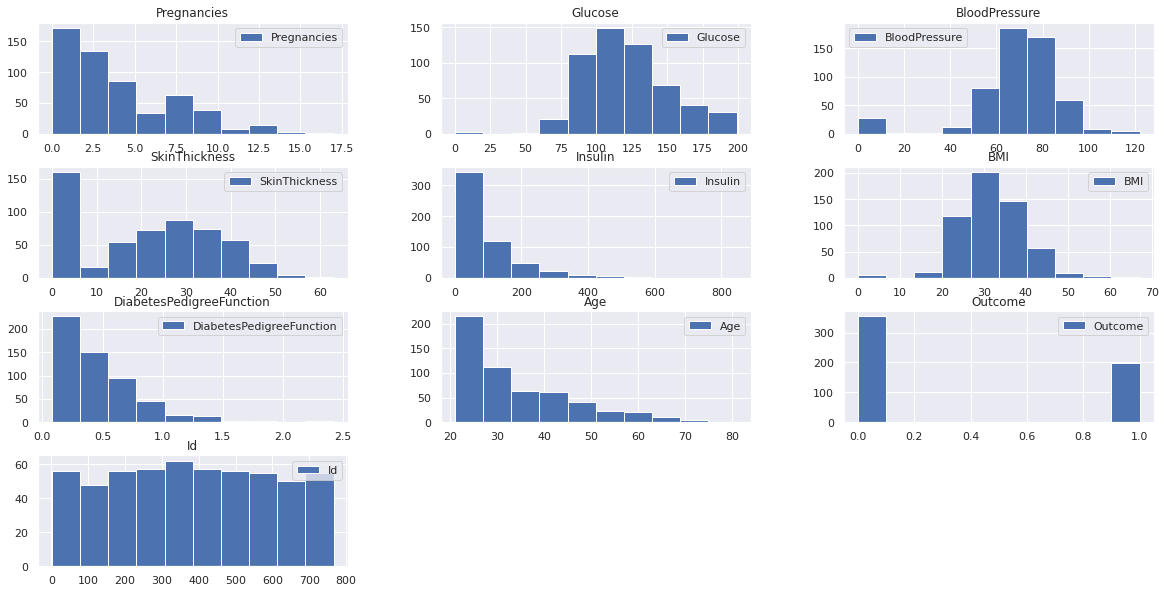

In [1753]:
train.hist(figsize=(20, 10), legend=True)

<AxesSubplot:>

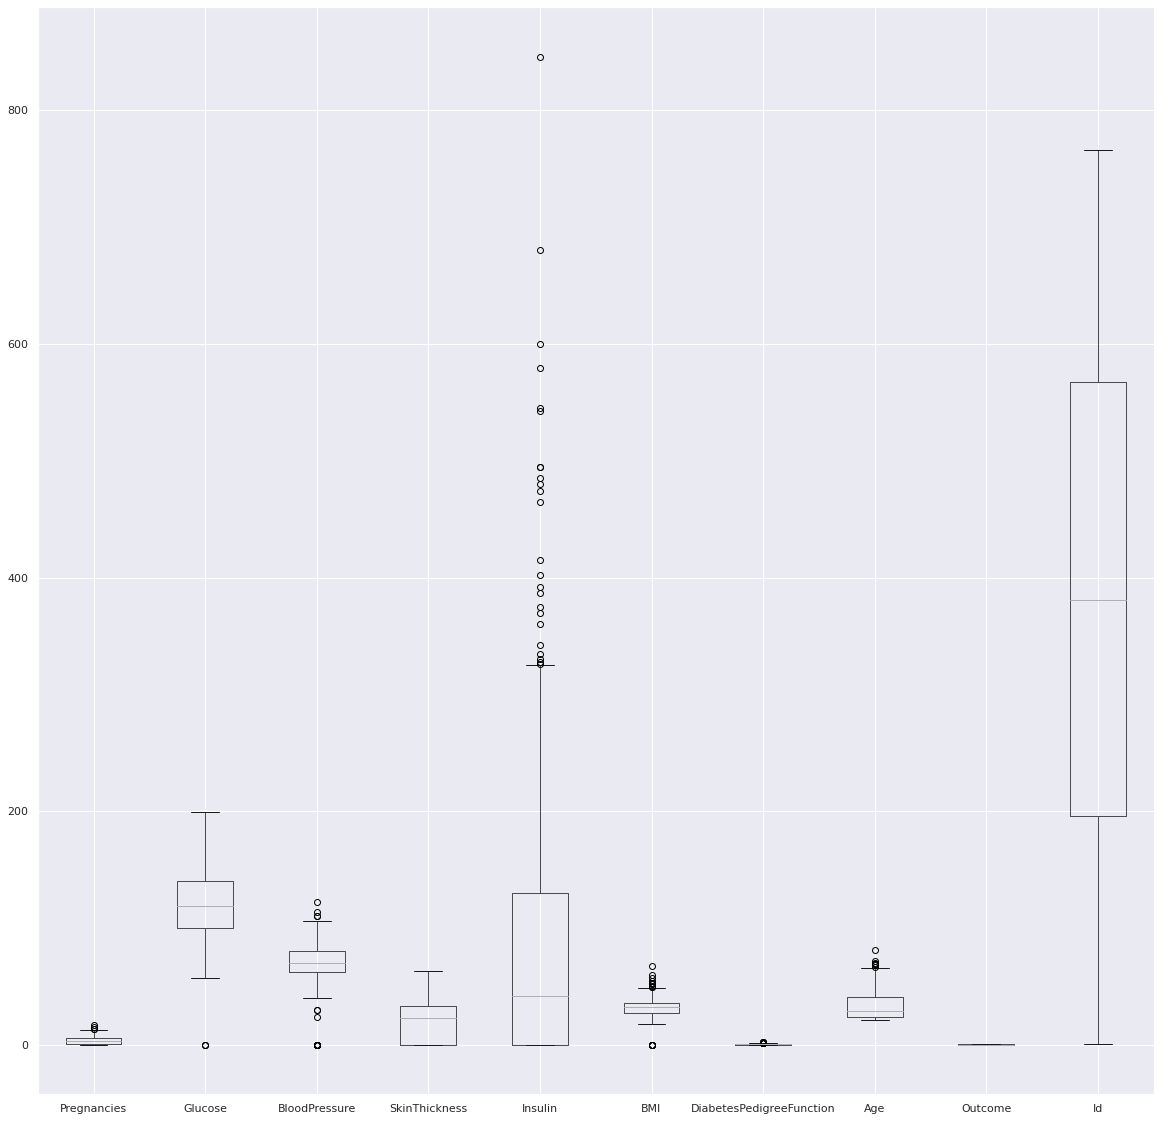

In [1754]:
train.boxplot(figsize=(20,20))

### Проверяем на выбросы через IQR

In [1755]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75]) #считаем 1 и 3 квартили
    iqr = quartile_3 - quartile_1 # считаем размер коробки
    lower_bound = quartile_1 - (iqr * 1.5) # метод межквартильного расстояния, чтобы определить границы
    upper_bound = quartile_3 + (iqr * 1.5) # метод межквартильного расстояния, чтобы определить границы
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [1756]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               552 non-null    int64  
 1   Glucose                   552 non-null    int64  
 2   BloodPressure             552 non-null    int64  
 3   SkinThickness             552 non-null    int64  
 4   Insulin                   552 non-null    int64  
 5   BMI                       552 non-null    float64
 6   DiabetesPedigreeFunction  552 non-null    float64
 7   Age                       552 non-null    int64  
 8   Outcome                   552 non-null    int64  
 9   Id                        552 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 43.2 KB


Проверяем Pregnancies

In [1757]:
Pregnancies_out = outliers_iqr(train.Pregnancies)

In [1758]:
train = train[~train.index.isin(Pregnancies_out)]
# train = train.drop(Pregnancies_out, axis=0)

In [1759]:
train = train[train['Pregnancies']<11]

Glucose

In [1760]:
Glucose_out = outliers_iqr(train['Glucose'])

In [1761]:
train = train[~train.index.isin(Glucose_out)]
# train = train.drop(Glucose_out, axis=0)

BloodPressure

<AxesSubplot:ylabel='BloodPressure'>

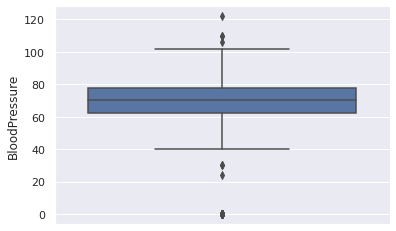

In [1762]:
sns.boxplot(y=train['BloodPressure'])

In [1763]:
BloodPressure_out = outliers_iqr(train['BloodPressure'])
BloodPressure_out

array([  6,  10,  12,  28,  33,  54,  56,  68,  85, 115, 118, 149, 170,
       177, 201, 228, 230, 239, 299, 302, 314, 324, 337, 345, 368, 370,
       408, 413, 416, 427, 443, 453, 475, 481])

In [1764]:
train = train[~train.index.isin(BloodPressure_out)]

In [1765]:
train = train[train['BloodPressure'] < 120]

In [1766]:
train = train[train['BloodPressure'] > 40]

In [1767]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 0 to 551
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               464 non-null    int64  
 1   Glucose                   464 non-null    int64  
 2   BloodPressure             464 non-null    int64  
 3   SkinThickness             464 non-null    int64  
 4   Insulin                   464 non-null    int64  
 5   BMI                       464 non-null    float64
 6   DiabetesPedigreeFunction  464 non-null    float64
 7   Age                       464 non-null    int64  
 8   Outcome                   464 non-null    int64  
 9   Id                        464 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 39.9 KB


SkinThickness

<AxesSubplot:ylabel='SkinThickness'>

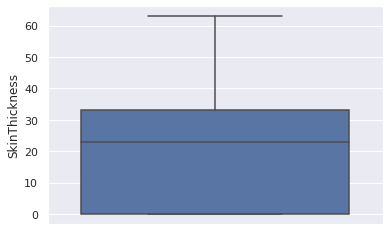

In [1768]:
sns.boxplot(y=train['SkinThickness'])

In [1769]:
SkinThickness_out = outliers_iqr(train['SkinThickness'])

In [1770]:
train = train[~train.index.isin(SkinThickness_out)]

In [1771]:
# train['SkinThickness'] = train['SkinThickness'].apply(lambda w: np.log(w+1))

Insulin

In [1772]:
Insulin_out = outliers_iqr(train['Insulin'])

In [1773]:
train = train[~train.index.isin(Insulin_out)]
train = train[train['Insulin']<300]

BMI

<AxesSubplot:ylabel='BMI'>

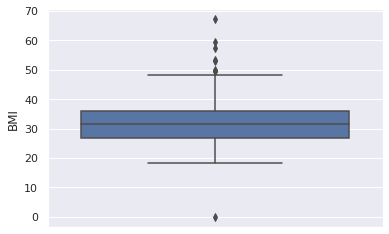

In [1774]:
sns.boxplot(y=train['BMI'])

In [1775]:
# BMI_out = outliers_iqr(train['BMI'])

In [1776]:
train = train[train['BMI']<45]

In [1777]:
train = train[train['BMI']>5]

DiabetesPedigreeFunction

<AxesSubplot:ylabel='DiabetesPedigreeFunction'>

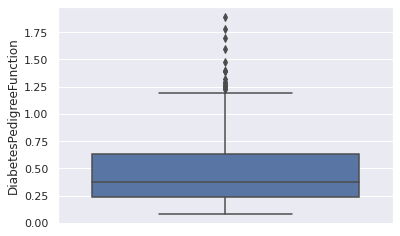

In [1778]:
sns.boxplot(y=train['DiabetesPedigreeFunction'])

In [1779]:
train = train[train['DiabetesPedigreeFunction']<1]

Age

<AxesSubplot:ylabel='Age'>

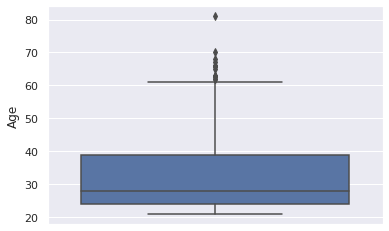

In [1780]:
sns.boxplot(y=train['Age'])

In [1781]:
train = train[train['Age']<55]

## Нормализация

In [1782]:
from sklearn.preprocessing import MinMaxScaler

In [1783]:
scaler = MinMaxScaler()
scaler.fit_transform(train)

array([[0.1       , 0.43367347, 0.35483871, ..., 0.3030303 , 0.        ,
        0.        ],
       [0.8       , 0.93367347, 0.32258065, ..., 0.33333333, 1.        ,
        0.00130719],
       [0.1       , 0.45408163, 0.35483871, ..., 0.        , 0.        ,
        0.00261438],
       ...,
       [0.2       , 0.62244898, 0.41935484, ..., 0.18181818, 0.        ,
        0.99738562],
       [0.5       , 0.61734694, 0.4516129 , ..., 0.27272727, 0.        ,
        0.99869281],
       [0.1       , 0.64285714, 0.25806452, ..., 0.78787879, 1.        ,
        1.        ]])

## Корреляции

<AxesSubplot:>

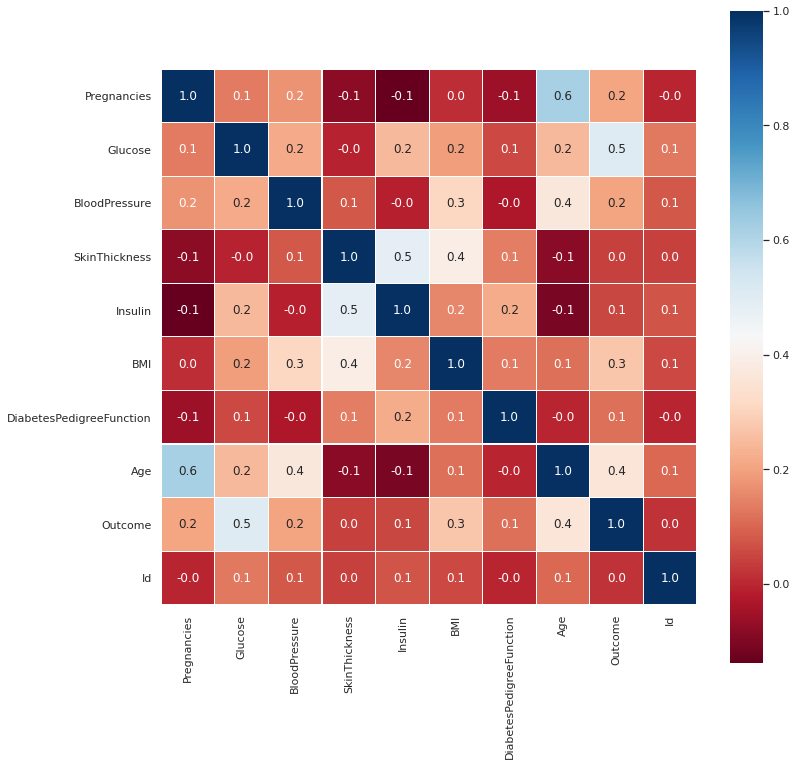

In [1784]:
sns.set(font_scale=1)
plt.subplots(figsize=(12,12))
sns.heatmap(train.corr(), square=True,
annot=True, fmt='.1f', linewidths=0.1, cmap='RdBu')

In [1785]:
balanced = train.groupby('Outcome')
balanced.apply(lambda x: x.sample(balanced.size().min()).reset_index(drop=True))

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
Outcome                                                                    
0       0              1       71             48             18       76   
        1              4      154             72             29      126   
        2              1       80             55              0        0   
        3              2      129             84              0        0   
        4              7      136             74             26      135   
...                  ...      ...            ...            ...      ...   
1       99            10      125             70             26      115   
        100            5      158             84             41      210   
        101            0      113             76              0        0   
        102            8      183             64              0        0   
        103            3      169             74             19      125   

              BMI  DiabetesPedigreeFunction  Age  Outcome   Id  
Outcome                                                         
0       0    20.4                     0.323   22        0   97  
        1    31.3                     0.338   37        0  568  
        2    19.1                     0.258   21        0   90  
        3    28.0                     0.284   27        0  251  
        4    26.0                     0.647   51        0  285  
...           ...                       ...  ...      ...  ...  
1       99   31.1                     0.205   41        1   25  
        100  39.4                     0.395   29        1  195  
        101  33.3                     0.278   23        1  124  
        102  23.3                     0.672   32        1    2  
        103  29.9                     0.268   31        1  696  

[208 rows x 10 columns]

<AxesSubplot:ylabel='Outcome-None'>

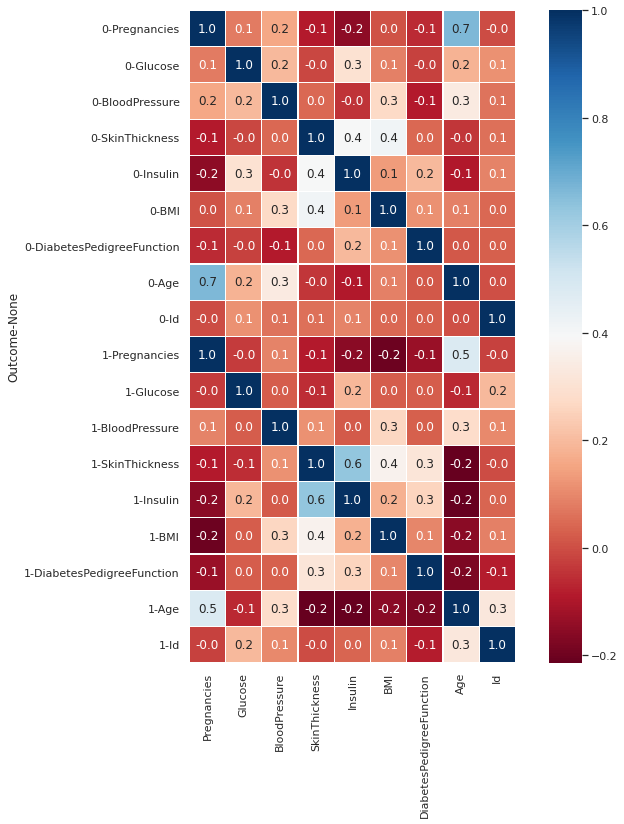

In [1786]:
sns.set(font_scale=1)
plt.subplots(figsize=(12,12))
sns.heatmap(balanced.corr(), square=True,
annot=True, fmt='.1f', linewidths=0.1, cmap='RdBu')

## Обучаем модель

In [1787]:
from sklearn.preprocessing import StandardScaler

In [1788]:
# scaler = StandardScaler()
# scaler.fit_transform(train)
# scaler.fit_transform(test)

### Логистическая регрессия

In [1789]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [1790]:
Y = train['Outcome']

In [1791]:
# X = train.drop(['Outcome', 'Id'], axis=1)
X = train[['Age', 'BMI', 'Glucose', 'Pregnancies', 'BloodPressure']]

In [1792]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=77)

In [1793]:
Model = LogisticRegression()

In [1794]:
Model.fit(X_train, Y_train)

LogisticRegression()

In [1795]:
Y_pred = Model.predict(X_val)

In [1796]:
f1_score(Y_val, Y_pred)

0.59375

### Логистическое дерево

In [1797]:
from sklearn.tree import DecisionTreeClassifier

In [1798]:
tree = DecisionTreeClassifier(min_samples_leaf=3, max_depth=4)

In [1799]:
tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3)

In [1800]:
Y_pred_tree = tree.predict(X_val)

In [1801]:
f1_score(Y_pred_tree, Y_pred)

0.7428571428571429

In [1802]:
submission = tree.predict(test[['Age', 'BMI', 'Glucose', 'Pregnancies', 'BloodPressure']])

In [1803]:
Y_test = pd.read_csv(DATA_DIR + 'sample_submission.csv')
Y_test_val = Y_test['Outcome']

In [1804]:
f1_score(Y_test_val, submission)

0.5928338762214983

In [1805]:
sample_submission['Outcome'] = submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Id,Outcome
0,0,1
1,9,0
2,11,1
3,12,1
4,14,1
5,17,1
6,20,0
7,22,1
8,24,1
9,26,1
